In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4403839%2F7563141%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240414%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240414T201632Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db1636cce05d7eab3fad6f2fc948fc7eb565c9fa3e8d6b1ed5682e3c52b04c60f894553361e5d6b7c49da1f8c0c07d2081fd6562df0df2485c28356adcaa2177db0ebf95e53828a30c62c6a7d8f7c4eea77d38675c97fe77fada8c5b4d1fe3ab7ec546afbba8faa8ce129b5e71c7c31c4a2fe8cd3410d00f6e70eb5be8061b8e3208615813d6e5065d21e57f53a24bf75cc8f9c9501a85118d1dec2fc750d06626f0dbb8d900713912f4ee8781fa2b3015a1975c3f1c92f5d95e4158693e6a4def2945c26ea0eef2b7421f1e677d0ed6a5fbdee082b184488a5c9e8b7a6dd179d96e53ebb20610dd45f86dd0525767169415dab83899e021a690e2c2e0f9021eb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16440679 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/text.csv


In [3]:
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification, AdamW
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.optim import Adam
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
df = pd.read_csv('/kaggle/input/text.csv')

In [8]:
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [9]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [11]:
df.duplicated().sum()

686

In [12]:
df = df.drop_duplicates()

In [13]:
df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [14]:
# Check the distribution of labels
label_counts = df['label'].value_counts()
label_counts

label
1    140779
0    120989
3     57235
4     47664
2     34497
5     14959
Name: count, dtype: int64

In [15]:
# Perform stratified sampling to create a balanced dataset
#balanced_df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(10000))

# Split the balanced dataset into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=50)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['label'], random_state=50)

# Check the distribution of labels in the balanced dataset
print(train_df['label'].value_counts())
print(val_df['label'].value_counts())
print(test_df['label'].value_counts())

label
1    112623
0     96791
3     45788
4     38131
2     27598
5     11967
Name: count, dtype: int64
label
1    14078
0    12099
3     5723
4     4766
2     3450
5     1496
Name: count, dtype: int64
label
1    14078
0    12099
3     5724
4     4767
2     3449
5     1496
Name: count, dtype: int64


In [16]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
# tokenize text data and encode labels
def preprocess_text(text):
    return tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=64,
        padding='max_length',
        truncation=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='pt'
    )

In [18]:
# apply preprocessing
train_df['input_ids'] = train_df['text'].apply(lambda x: preprocess_text(x)['input_ids'])
train_df['attention_mask'] = train_df['text'].apply(lambda x: preprocess_text(x)['attention_mask'])

val_df['input_ids'] = val_df['text'].apply(lambda x: preprocess_text(x)['input_ids'])
val_df['attention_mask'] = val_df['text'].apply(lambda x: preprocess_text(x)['attention_mask'])

test_df['input_ids'] = test_df['text'].apply(lambda x: preprocess_text(x)['input_ids'])
test_df['attention_mask'] = test_df['text'].apply(lambda x: preprocess_text(x)['attention_mask'])

# convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['label'].values)
val_labels = torch.tensor(val_df['label'].values)
test_labels = torch.tensor(test_df['label'].values)

In [19]:
# custom PyTorch Dataset
class EmotionsDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

train_dataset = EmotionsDataset(train_df['input_ids'].tolist(), train_df['attention_mask'].tolist(), train_labels)
val_dataset = EmotionsDataset(val_df['input_ids'].tolist(), val_df['attention_mask'].tolist(), val_labels)
test_dataset = EmotionsDataset(test_df['input_ids'].tolist(), test_df['attention_mask'].tolist(), test_labels)

# create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
from transformers import get_linear_schedule_with_warmup

In [21]:

num_classes = len(train_df['label'].unique())

epochs = 5

total_steps = len(train_loader) * epochs

# pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

dropout_rate = 0.5
model.dropout1 = nn.Dropout(dropout_rate)

# Batch normalization
batch_norm = nn.BatchNorm1d(768)

model.dropout2 = nn.Dropout(dropout_rate)

# optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# loss function
loss_fn = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [22]:

num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:

        inputs = batch['input_ids'].squeeze(1).to(device)
        attention_masks = batch['attention_mask'].squeeze(1).to(device)
        labels = batch['labels'].to(device)

        # clear gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs, attention_mask=attention_masks, labels=labels)

        # compute loss
        loss = outputs.loss

        # backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    # calc avg training loss
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}: Avg. Training Loss: {avg_train_loss:.4f}")

    # validation loop
    model.eval()
    val_loss = 0.0
    num_val_batches = len(val_loader)
    val_preds = []
    val_true_labels = []

    with torch.no_grad():
        for val_batch in val_loader:
            val_inputs = val_batch['input_ids'].squeeze(1).to(device)
            val_attention_masks = val_batch['attention_mask'].squeeze(1).to(device)
            val_true = val_batch['labels'].to(device)

            val_outputs = model(val_inputs, attention_mask=val_attention_masks, labels=val_true)
            val_loss += val_outputs.loss.item()

            # store predictions
            val_preds.extend(torch.argmax(val_outputs.logits, axis=1).cpu().numpy().tolist())
            val_true_labels.extend(val_true.cpu().numpy().tolist())

    avg_val_loss = val_loss / num_val_batches
    print(f"Epoch {epoch+1}/{num_epochs}: Avg. Validation Loss: {avg_val_loss:.4f}")

    # eval metrics
    val_accuracy = accuracy_score(val_true_labels, val_preds)
    val_f1 = f1_score(val_true_labels, val_preds, average='weighted')
    print(f"Epoch {epoch+1}/{num_epochs}: Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}")

Epoch 1/3: Avg. Training Loss: 0.1270
Epoch 1/3: Avg. Validation Loss: 0.0869
Epoch 1/3: Validation Accuracy: 0.9435, Validation F1 Score: 0.9419
Epoch 2/3: Avg. Training Loss: 0.0875
Epoch 2/3: Avg. Validation Loss: 0.0858
Epoch 2/3: Validation Accuracy: 0.9436, Validation F1 Score: 0.9425
Epoch 3/3: Avg. Training Loss: 0.0823
Epoch 3/3: Avg. Validation Loss: 0.0864
Epoch 3/3: Validation Accuracy: 0.9419, Validation F1 Score: 0.9399


In [23]:
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for test_batch in test_loader:
        test_inputs = test_batch['input_ids'].squeeze(1).to(device)
        test_attention_masks = test_batch['attention_mask'].squeeze(1).to(device)
        test_true_labels = test_batch['labels'].to(device)

        # forward pass test
        test_outputs = model(test_inputs, attention_mask=test_attention_masks)

        # store predictions
        test_preds.extend(torch.argmax(test_outputs.logits, axis=1).cpu().numpy().tolist())
        test_labels.extend(test_true_labels.cpu().numpy().tolist())

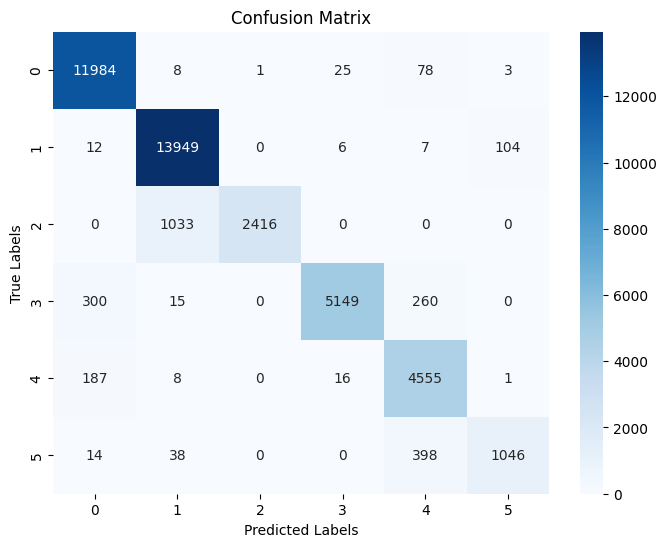

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [25]:
print("\nConfusion matrix - BERT:")
conf_matrix


Confusion matrix - BERT:


array([[11984,     8,     1,    25,    78,     3],
       [   12, 13949,     0,     6,     7,   104],
       [    0,  1033,  2416,     0,     0,     0],
       [  300,    15,     0,  5149,   260,     0],
       [  187,     8,     0,    16,  4555,     1],
       [   14,    38,     0,     0,   398,  1046]])

In [27]:
from sklearn.metrics import classification_report
# Generate classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     12099
           1       0.93      0.99      0.96     14078
           2       1.00      0.70      0.82      3449
           3       0.99      0.90      0.94      5724
           4       0.86      0.96      0.91      4767
           5       0.91      0.70      0.79      1496

    accuracy                           0.94     41613
   macro avg       0.94      0.87      0.90     41613
weighted avg       0.94      0.94      0.94     41613





1.   Precision: The model was good at predicting emotions like sadness,joy, anger and fear.  
2.   Recall: For love and surprise, the model ccan perform better.
3.   F1-Score: This score shows a balance between correctly spotting an emotion and not mistakenly thinking it's there. The model did well overall but needs work on emotions like love and surprise, where it struggled to detect them.



>  Overall, the model balanced between making correct predictions and avoiding mistakes but it can be refined for love and surprise emotions.



# BERT vs LSTM performance:

**BERT Model:**
The BERT model demonstrates high precision across multiple emotional categories which shows the model is robust and is able to accurately identify sentiments such as sadness, joy, and anger. Its high precision suggests a low rate of false positives, making it a reliable tool for sentiment analysis and emotional recognition.

**LSTM Model:**
While the LSTM model also performs relatively well in identifying emotions, it exhibits slightly lower precision compared to BERT. This model may encounter occasional challenges, particularly with emotions like surprise and love, where its precision and accuracy show minor fluctuations.

> Overall, the BERT model presents a highly dependable solution with consistently high precision as compared to the LSTM model in predicting emotions.

